# Introduction
### Machine Learning Based Fraud Detection System
The global rise in online fraud, coupled with the dynamic nature of fraudulent activities, necessitates an initiative-taking and adaptive approach to fraud detection. Our goal seeks to leverage advanced technologies to stay ahead of emerging threats and provide a secure financial environment for our customers. In this notebook we use Logistic Regression & Random Forest Machine Learning Models to achieve our goals.


 # Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import  f1_score, roc_auc_score, roc_curve#
from matplotlib.colors import LinearSegmentedColormap

# Load Data

### Data Attributes
This Dataset sourced by some unnamed institute.

Feature Explanation:


<mark>distance_from_home</mark> - the distance from home where the transaction happened.

<mark>distance_from_last_transaction</mark> - the distance from last transaction happened.

<mark>ratio_to_median_purchase_price</mark> - Ratio of purchased price transaction to median purchase price.

<mark>repeat_retailer</mark> - Is the transaction happened from same retailer.

<mark>used_chip</mark> - Is the transaction through chip (credit card).

<mark>used_pin_number</mark> - Is the transaction happened by using PIN number.

<mark>online_order</mark> - Is the transaction an online order.

<mark>fraud</mark> - Is the transaction fraudulent.

In [2]:
# Load the dataset
df = pd.read_csv("../../data/card_transdata.csv")

# Data Prev
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


# Explore Data

We want a quick peek of our data summary

In [3]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


<!-- Create a custom color palette and Plot count plot -->
<section>
  <h1>Create a custom color palette and Plot count plot</h1>
  <p>Creates a custom color palette with alternating black and green. Prints raw and normalized counts of 'fraud' in the dataset. Plots a count plot with alternating black and green bars.</p>

Quick look at some of the features and their distribution

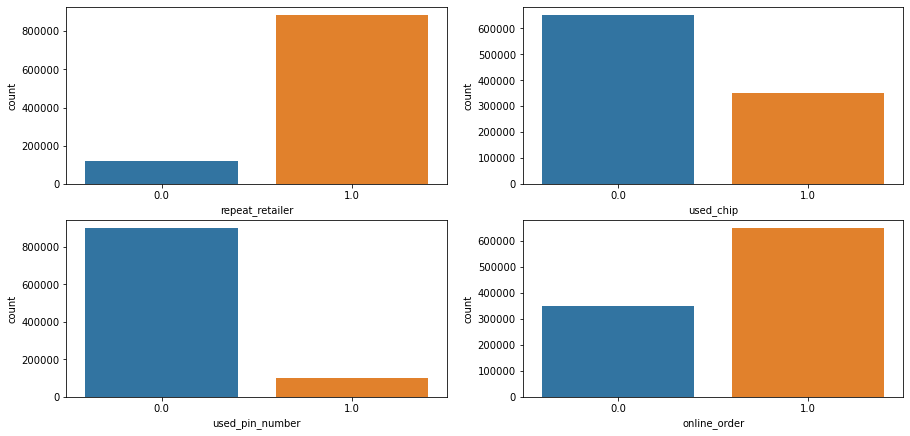

In [4]:
plt.figure(figsize=(15, 15))

plt.subplot(4,2,1)
sns.countplot(x = 'repeat_retailer', data = df)
plt.subplot(4,2,2)
sns.countplot(x = 'used_chip', data = df)
plt.subplot(4,2,3)
sns.countplot(x = 'used_pin_number', data = df)
plt.subplot(4,2,4)
sns.countplot(x = 'online_order', data = df)
plt.show()

Let's take a quick look at our target variable 'fraud' and the counts between 1 & 0

Raw counts: 

0.0    912597
1.0     87403
Name: fraud, dtype: int64
-----------------------------------
Normalized counts: 

0.0    0.912597
1.0    0.087403
Name: fraud, dtype: float64


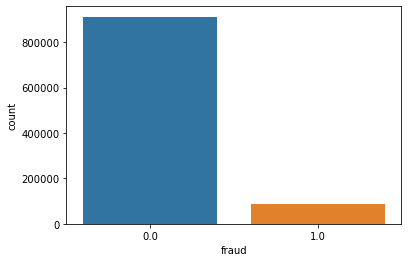

In [5]:
print('Raw counts: \n')
print(df['fraud'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(df['fraud'].value_counts(normalize=True))
ax=sns.countplot (x=df['fraud'], data=df)

### Data is imbalanced
more than 91% of data are Genuine transactions
more than 8% of data are Fraud transactions

Accuracy is a not a good metric for imbalance data set. It won't provide a great picture for the model's overall performance. In imbalanced data sets, the model can predict the majority class and achieve a high score. Aka it's seen more of the majority class and it will simply predict that, in this case it can predict genuine 100% and will be correct 91% of the time. However, it ignore approximately 9% of the time and that 9% is very significant because those are false negative which can cost a lot of money to the firm. 

Example: a fraud transaction is called genuine, where the transaction withdraw $50 dollars from a random bank customer. Not only did the customer lose 50 bucks, it also lost the trust to the bank. This is a lost lost situation. Imagine a bigger number, let's say 1 million. How would you feel?

Take a look at the pairwise relationships between variables in our data set.

We will witness that strong positive or negative relationships between variables does not occur in this heatmap

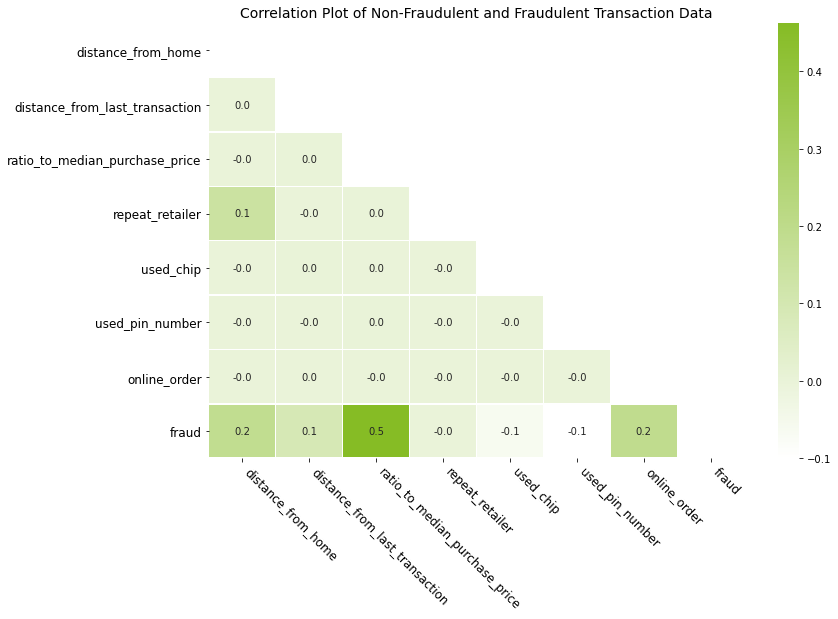

In [49]:
# Define Deloitte green color in RGB
deloitte_green_rgb = (134/255, 188/255, 37/255)

# Create a custom colormap with a gradient from white to Deloitte green
cmap = LinearSegmentedColormap.from_list('deloitte_green_gradient', ['white', deloitte_green_rgb])

# Create a mask DataFrame with the same shape as the original DataFrame
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap with the specified colormap and mask
heatmap = sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt='.1f', cmap=cmap, mask=mask)

# Rotate x-axis labels by 45 degrees
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=-45, ha='left', fontsize=12)  # Adjust fontsize for x-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right', fontsize=12)   # Adjust fontsize for y-axis labels

plt.title('Correlation Plot of Non-Fraudulent and Fraudulent Transaction Data', fontsize=14)  # Adjust title fontsize
plt.show()

In [7]:
# Split the data into features (X) and the target variable (y)
X = df.drop("fraud", axis=1)
y = df["fraud"]

In [8]:
# Split the data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Data Preprocessing: Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models

Create a baseline model using logistic regression to get a baseline score

In [10]:
# create logistic regression
lr_model = LogisticRegression().fit(X_train,y_train)
y_pred = lr_model.predict(X_test)
y_score = lr_model.predict_proba(X_test)[:, 1]

In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_score)
print("AUC", auc(fpr, tpr))

Accuracy: 0.9594
Precision: 0.8963502413413498
Recall: 0.605514558663692
F1 Score: 0.7227722772277227
AUC 0.9669906786257931


We have a strong baseline model, but we hope to make it better on the next iterations on the model.
Note: This model does not use resampled data

# Resampling 

Smote uses both under sampling and over sampling techniques.
In this case it under samples the majority group and over samples the minority group creating synthetic data

Applies logistic regression on the resampled training data.
Prints the logistic regression model, predicts on the test set, and evaluates performance metrics such as AUC, accuracy, precision, recall, and F1 score.

In [12]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

In [13]:
# Create an even distribution between the target variables using smote 
# This is the first Logistic Regression with resampled data using default smote parameters
logreg = LogisticRegression(fit_intercept=False, C=1e20, solver ='lbfgs')
model_log = logreg.fit(X_train_resampled, y_train_resampled)
print(model_log)

# Predict
y_hat_test = logreg.predict(X_test)

y_score = logreg.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 
print("auc", auc(fpr, tpr))
print("Accuracy:", accuracy_score(y_test, y_hat_test))    
print("Precision:", precision_score(y_test, y_hat_test))
print("Recall:", recall_score(y_test, y_hat_test))
print("F1 Score:", f1_score(y_test, y_hat_test))

LogisticRegression(C=1e+20, fit_intercept=False)
-----------------------------------------
Synthetic sample class distribution: 

1.0    730078
0.0    730078
Name: fraud, dtype: int64
auc 0.972402368833988
Accuracy: 0.7398
Precision: 0.25144920239927504
Recall: 1.0
F1 Score: 0.40185283096940294


Text(0.5, 1.0, 'Confusion Matrix: Assessing Credit Card Fraud Detection Performance')

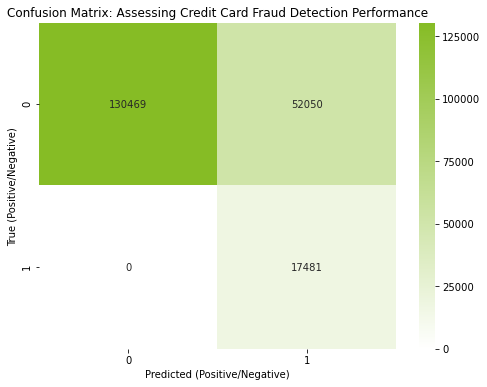

In [64]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)

# Define Deloitte green color in RGB
deloitte_green_rgb = (134/255, 188/255, 37/255)

# Define your custom gradient from Deloitte green to white
custom_gradient = {
    'red':   ((0.0, 1.0, 1.0),
              (1.0, deloitte_green_rgb[0], deloitte_green_rgb[0])),
    'green': ((0.0, 1.0, 1.0),
              (1.0, deloitte_green_rgb[1], deloitte_green_rgb[1])),
    'blue':  ((0.0, 1.0, 1.0),
              (1.0, deloitte_green_rgb[2], deloitte_green_rgb[2]))
}

# Create a custom colormap using the defined gradient
custom_cmap = LinearSegmentedColormap('custom_colormap', custom_gradient)

# Assuming 'conf_matrix' is your confusion matrix
plt.figure(figsize=(8, 6))

# Plot the heatmap using the custom colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_cmap)

# Customize the colorbar
cbar = heatmap.collections[0].colorbar
# Add ticks from 0 to 175000, increasing by 25000
cbar.set_ticks(np.arange(0, 200000, 25000))

plt.xlabel('Predicted (Positive/Negative)')
plt.ylabel('True (Positive/Negative)')
plt.title('Confusion Matrix: Assessing Credit Card Fraud Detection Performance')

This confusion matrix. Does well preventing fraud, but lots of false positive may deteriorates transaction efficiency. However, there are not false negative therefore customer trust won't be damaged.

## Comparing different resampling ratios

Here we take different resampling ratio to check the strength of our models at each given ratio.

LogisticRegression(C=1e+20, fit_intercept=False)
-----------------------------------------
Synthetic sample class distribution: 

0.0    730078
1.0     73007
Name: fraud, dtype: int64
AUC for 0.1: 0.9667469688432028
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
-----------------------------------------
Synthetic sample class distribution: 

0.0    730078
1.0    182519
Name: fraud, dtype: int64
AUC for 0.25: 0.9693459022583016
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
-----------------------------------------
Synthetic sample class distribution: 

0.0    730078
1.0    240925
Name: fraud, dtype: int64
AUC for 0.33: 0.9701636644437147
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
-----------------------------------------
S

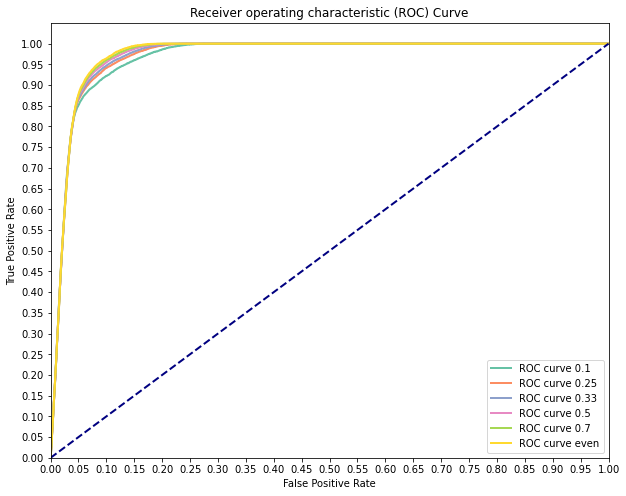

In [14]:
# Now let's compare a few different ratios of minority class to majority class
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
    logreg = LogisticRegression(fit_intercept=False, C=1e20, solver ='lbfgs')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('-----------------------------------------')
    print('Synthetic sample class distribution: \n')
    print(pd.Series(y_train_resampled).value_counts()) 
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

As you can see there seems to be a positive correlation between increasing the minority class to meet the majority class(oversampling) as shown in the text results and the AUC graph

# Random Forest Model

<!-- Train Random Forest Model and Perform Hyperparameter Tuning -->
<section>
  <h1>Train Random Forest Model and Perform Hyperparameter Tuning</h1>
  <p>Trains a Random Forest model on SMOTE-enhanced training data. Defines hyperparameters for tuning (number of estimators, max depth, min samples split, min samples leaf). Uses GridSearchCV to perform hyperparameter tuning and prints the best parameters and ROC AUC score.</p>
</section>

In [15]:
# Train your model on SMOTE-enhanced training data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [16]:
# Define hyperparameters to tune
# might take a bit to run
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create a GridSearchCV instance with verbose=1
grid_search = GridSearchCV(rf_model, param_grid, scoring='roc_auc', cv=2, n_jobs=8, verbose=3)

In [17]:
# Perform grid search for hyperparameter tuning
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done  28 out of  32 | elapsed: 13.5min remaining:  1.9min
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed: 15.3min finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=8,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='roc_auc', verbose=3)

In [18]:
print("Best Parameters: ", grid_search.best_params_)
print("Best ROC AUC Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best ROC AUC Score:  0.9999999864600151


<!-- Visualize GridSearchCV Results -->
<section>
  <h1>Visualize GridSearchCV Results</h1>
  <p>Visualizes GridSearchCV results by plotting mean scores with error bars. Uses Deloitte green color for visualization. Prints a statement indicating successful cross-validation.</p>
</section>

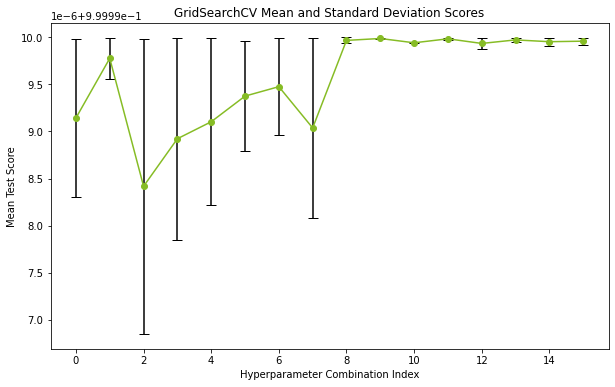

In [65]:
# Define Deloitte green color in RGB
deloitte_green_rgb = (134/255, 188/255, 37/255)

# Access mean and std scores
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

# Plot mean scores with error bars using Deloitte green color
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(mean_scores)), mean_scores, yerr=std_scores, fmt='o-', color=deloitte_green_rgb, ecolor='black', capsize=5)
plt.title('GridSearchCV Mean and Standard Deviation Scores')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test Score')
plt.show()

In [20]:
# Print the statement with actual values for cross-validation check
print(f"The GridSearchCV results indicate a successful cross-validation with optimal hyperparameter values selected. Mean cross-validated score: {mean_scores.mean():.4f}, Standard deviation of the cross-validated scores: {std_scores.mean():.4f}.")

The GridSearchCV results indicate a successful cross-validation with optimal hyperparameter values selected. Mean cross-validated score: 1.0000, Standard deviation of the cross-validated scores: 0.0000.


<!-- Evaluate the Best Model -->
<section>
  <h1>Evaluate the Best Model</h1>
  <p>Uses the best model obtained from GridSearchCV to make predictions on the test set.</p>
</section>

In [22]:
# Get the best model
best_rf_model = grid_search.best_estimator_

In [23]:
# Evaluate the best model
y_pred_rf = best_rf_model.predict(X_test)

<!-- Evaluation Metrics for Random Forest -->
<section>
  <h1>Evaluation Metrics for Random Forest</h1>
  <p>Calculates and prints various evaluation metrics for the Random Forest model on the test set.</p>
</section>

In [24]:
# Evaluation Metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

# Display Results for Random Forest
print("Random Forest Model with SMOTE Training Data Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print(f"ROC AUC: {roc_auc_rf}")

Random Forest Model with SMOTE Training Data Metrics:
Accuracy: 0.999975
Precision: 0.9999427852156998
Recall: 0.999771180138436
F1 Score: 0.9998569753139392
ROC AUC: 0.9998828506283927


<!-- Confusion Matrix Visualization -->
<section>
  <h1>Confusion Matrix Visualization</h1>
  <p>Computes and visualizes the confusion matrix using a custom gradient colormap. Deloitte green is used for visualization.</p>
</section>

Text(0.5, 1.0, 'Confusion Matrix: Assessing Credit Card Fraud Detection Performance')

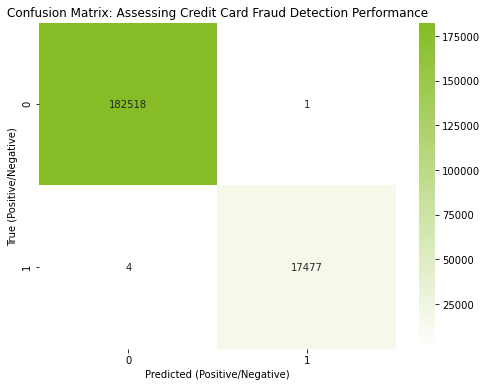

In [33]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Define Deloitte green color in RGB
deloitte_green_rgb = (134/255, 188/255, 37/255)

# Define your custom gradient from Deloitte green to white
custom_gradient = {
    'red':   ((0.0, 1.0, 1.0),
              (1.0, deloitte_green_rgb[0], deloitte_green_rgb[0])),
    'green': ((0.0, 1.0, 1.0),
              (1.0, deloitte_green_rgb[1], deloitte_green_rgb[1])),
    'blue':  ((0.0, 1.0, 1.0),
              (1.0, deloitte_green_rgb[2], deloitte_green_rgb[2]))
}

# Create a custom colormap using the defined gradient
custom_cmap = LinearSegmentedColormap('custom_colormap', custom_gradient)

# Assuming 'conf_matrix' is your confusion matrix
plt.figure(figsize=(8, 6))

# Plot the heatmap using the custom colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_cmap)

# Customize the colorbar
cbar = heatmap.collections[0].colorbar
# Add ticks from 0 to 175000, increasing by 25000
cbar.set_ticks(np.arange(0, 200000, 25000))

plt.xlabel('Predicted (Positive/Negative)')
plt.ylabel('True (Positive/Negative)')
plt.title('Confusion Matrix: Assessing Credit Card Fraud Detection Performance')

<!-- ROC Curve Visualization -->
<section>
  <h1>ROC Curve Visualization</h1>
  <p>Calculates and plots the ROC curve for the best Random Forest model. Deloitte green and black lines are used for visualization.</p>
</section>

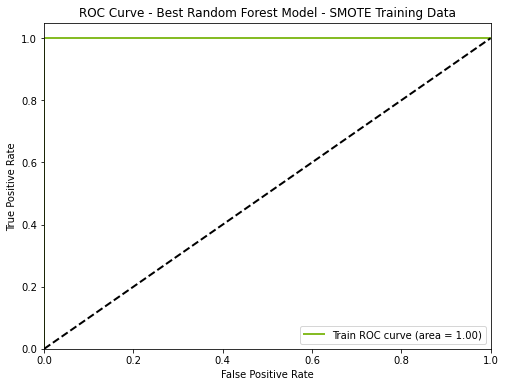

In [32]:
# Define Deloitte green color in RGB
deloitte_green_rgb = (134/255, 188/255, 37/255)

# Calculate ROC curve and ROC AUC for best_rf_model
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_resampled, best_rf_model.predict_proba(X_train_resampled)[:, 1])
roc_auc_train = roc_auc_score(y_train_resampled, best_rf_model.predict(X_train_resampled))

# Plot ROC curve with Deloitte green and black lines
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color=deloitte_green_rgb, lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Black dotted line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Random Forest Model - SMOTE Training Data')
plt.legend(loc="lower right")
plt.show()


# `

# Conclusion

Our proposed AI model strategically tackles the challenge of false negatives, reinforcing our commitment to robust fraud prevention. This business case emphasizes the urgeerational efficiency.ncy, challenges, and objectives, promising transformative impacts on customer satisfaction, financial security, and op

The fraud detection bid timeline outlines a journey from the current legacy system to full integration, projecting reduced fraud rates and heightened customer satisfaction. Our objectives center on AI's ability to minimize false positives, elevate customer satisfaction, and fortify financial security.

The Random Forest model and confusion matrix showcased today demonstrate outstanding performance, effectively mitigating both false positives and false negatives. The success of our approach hinges on projected Return on Investment (ROI), customer loyalty, sustained model accuracy, and regulatory compliance.

Understanding the impacts of false positives and false negatives, our model seeks equilibrium, minimizing disruptions for consumers while safeguarding customer trust.